In [1]:
import sys
import os
if not any(path.endswith('textbook') for path in sys.path):
    sys.path.append(os.path.abspath('../../..'))
from textbook_utils import *

(sec:linear_case)=
# Example: Where is the Land of Opportunity?

The US was nicknamed "the land of opportunity" because people believed that
even poor people in the US could end up wealthy---economists call this 
economic mobility. 
In a famous study, the economist Raj Chetty and his colleagues
did a large-scale data analysis on 
economic mobility in the US {cite}`chettyWhere2014`.
But Chetty had a hunch that some places in the US have much higher economic
mobility than others.
His analysis found this to be true.
Cities like San Jose, Washington DC, and Seattle have higher
mobility than places like Charlotte, Milwaukee, and Atlanta.
This means that overall, more people move from low income to high
income in San Jose compared to Charlotte.
Chetty also used linear models to find out that social and economic
factors like segregation, income inequality, and local school systems 
are related to economic mobility.
In this chapter, we'll use linear models to replicate parts of his analysis.

To do his analysis, Chetty used government tax records to get the incomes of
everyone born in the US between 1980-82.
He looked at each person's income in 2011-12 when they were about
30 years old, and compared it to their parents' income when they were born.
In total, his dataset had about 10 million people.
To define economic mobility, Chetty took the people who were born into the
25th income percentile and found the income percentile they ended up with
30 years later. He called this statistic the *absolute upward mobility* (AUM).
If a region's average AUM is 25, then people in the 25th percentile generally
stay in the 25th percentile---they stay where they are.
High AUM values mean that the region has high mobility.
People in these regions generally make more than their parents.
For reference, the US average AUM is about 41 at the time of this writing.
Chetty averaged together the AUMs for regions of the US called commuting zones
(CZ).
Commuting zones are defined by the economy of a region and are on the 
same scale as counties. 
While individual income records can't be publicly available because of privacy,
the AUMs for each commuting zone are publicly available.
Since Chetty also used commuting zone AUMs, we can replicate his analysis
using publicly available data.

So, our outcome variable $ y $ represents the AUM for a commuting zone.
There are many possible predictor variables in Chetty's data.
For our first simple linear model, we'll pick the predictor variable
$ x $ to be the
fraction of people who have a 15-minute or shorter commute to work.

## Explaining Upward Mobility using Commute Time

Let's take a look at the Opportunity data.
We'll load the data into the `df` variable.

In [11]:
df = (
    pd.read_csv('data/mobility.csv')
    # filter out rows with NaN AUM values
    .query('not aum.isnull()', engine='python')
)
df

,cz,czname,stateabbrv,aum,...,cs_fam_wkidsinglemom,cs_divorced,cs_married,incgrowth0010
0,100.0,Johnson City,TN,38.39,...,0.19,0.11,0.60,-2.28e-03
1,200.0,Morristown,TN,37.78,...,0.19,0.12,0.61,-2.15e-03
2,301.0,Middlesborough,TN,39.05,...,0.21,0.11,0.59,-3.71e-03
...,...,...,...,...,...,...,...,...,...
738,39302.0,Bellingham,WA,44.12,...,0.19,0.10,0.54,-6.95e-03
739,39303.0,Port Angeles,WA,41.41,...,0.24,0.12,0.60,4.91e-05
740,39400.0,Seattle,WA,43.20,...,0.19,0.12,0.54,-1.55e-03


Each row in `df` represents one commuting zone.
The column `aum` has the average AUM metric for each commuting zone.
There are many columns in `df` since this dataframe also has the
covariates for each CZ.
For our simple linear model, we want the
`frac_traveltime_lt15` column which has the fraction of people
in each CZ that have a 15 minute or shorter commute time.
We'll plot `aum` against `frac_traveltime_lt15` to see the
relationship between the two variables.

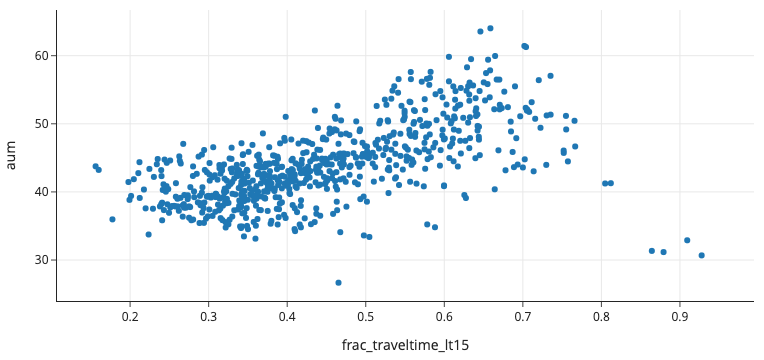

In [6]:
px.scatter(df, x='frac_traveltime_lt15', y='aum',
           width=350, height=250)

Our model is $ f_{\theta}(x) = \theta_0 + \theta_1 x $ where
$ x $ is the `frac_traveltime_lt15` for a commuting zone and
the predicted outcome $ y $ is the `aum`.
By looking at the scatter plot above, we can guess that $ \theta_1 $ should be
positive since `aum` is bigger for bigger values of `frac_traveltime_lt15`.
In the next section, we'll use loss minimization to find
$ \theta_0 $ and $ \theta_1 $ precisely.

In the equations above, $ \theta_0 $ and $ \theta_1 $ are constants that
we call the *model parameters*.
It's custom to say that the column vector $ \theta = [ \theta_0, \theta_1 ] $.
So, $ \theta $ is a vector that contains all of the model parameters,
and $ \theta_1 $ is a scalar that represents a single model parameter.
The first steps in modeling are to pick $ x $ and $ y $, then 
figure out what $ \theta_0 $ and $ \theta_1 $ are.

:::{note}

We'll work with $ \epsilon $ more rigorously in future chapters.
For now, the important idea to remember is that the model depends on
$ x $. For example,
when $ \theta_1 $ is positive, bigger values of $ x $ make the
prediction $ f_{\theta}(x) $ bigger.

:::

## Explaining Upward Mobility Using Multiple Variables

Before, we used the fraction of people with a ≤15 min commute time to predict
the AUM for a commuting zone.
Now, we'd like to use a combination of predictors.
In his original analysis, Chetty created nine high-level
predictor categories like segregation, income, and K-12 education.
We'll take one predictor from each of Chetty's categories for a total of
nine predictors, described in {numref}`Table %s <tbl:linear-predictors>`.

:::{table} The nine variables we use to predict AUM
:name: tbl:linear-predictors

| Column name | Description |
| ----------- | ----------- |
| frac_traveltime_lt15 | Fraction of people with a ≤15 minute commute to work.
| gini | Gini coefficient, an measure of wealth inequality. Values are between 0 and 1, where small values mean wealth is evenly distributed and large values mean more inequality.
| dropout_r | High school dropout rate.
| rel_tot | Fraction of people who self-reported as religious.
| cs_fam_wkidsinglemom | Fraction of children with a single mother.
| taxrate | Local tax rate.
| gradrate_r | College graduation rate.
| frac_worked1416 | Fraction of teenagers who are working.
| cs_born_foreign | Fraction of people born outside the US.
:::

Our original dataframe has around 40 predictors:

In [4]:
df.head(2)

,cz,czname,stateabbrv,aum,...,cs_fam_wkidsinglemom,cs_divorced,cs_married,incgrowth0010
0,100.0,Johnson City,TN,38.39,...,0.19,0.11,0.60,-2.28e-03
1,200.0,Morristown,TN,37.78,...,0.19,0.12,0.61,-2.15e-03


We'll subset out the design matrix into a DataFrame `X` and
the column of outcomes into a Series `y`.

In [13]:
predictors = [
    'frac_traveltime_lt15',
    'gini',
    'dropout_r',
    'rel_tot',
    'cs_fam_wkidsinglemom',
    'taxrate',
    'gradrate_r',
    'frac_worked1416',
    'cs_born_foreign',
]

X = (df[predictors]
    # Some predictors are missing; we'll drop them for simplicity
    .dropna()
    .assign(intr=1)
    # Move intercept column to appear first
    [['intr', *predictors]]
)
y = df.loc[X.index, 'aum']
X = X.reset_index(drop=True)
y = y.reset_index(drop=True)

In [18]:
print(f'X: {X.shape} matrix')
print(f'y: {y.shape} vector')

X: (479, 10) matrix
y: (479,) vector


Let's look at `X`, a dataframe that we're using as our design matrix.
It has 479 observations and 9 predictors plus an intercept column:

In [19]:
X

,intr,frac_traveltime_lt15,gini,dropout_r,...,taxrate,gradrate_r,frac_worked1416,cs_born_foreign
0,1,0.33,0.47,-1.53e-02,...,0.02,-2.43e-03,3.75e-03,1.18e-02
1,1,0.28,0.43,-2.35e-02,...,0.02,-1.01e-01,4.78e-03,2.31e-02
2,1,0.36,0.44,-4.63e-03,...,0.01,1.11e-01,2.89e-03,7.08e-03
...,...,...,...,...,...,...,...,...,...
476,1,0.45,0.36,7.07e-03,...,0.02,-4.30e-02,4.33e-03,1.12e-01
477,1,0.65,0.36,-1.53e-02,...,0.02,-4.94e-02,4.30e-03,2.33e-02
478,1,0.47,0.44,2.61e-03,...,0.02,-2.70e-01,5.46e-03,3.69e-02


Notice that our design matrix is a subset of our original dataframe---we just
selected specific variables we want to use for prediction.
Each row of our design matrix corresponds to an observation in our original
data, and each column corresponds to a predictor variable, as depicted in
{numref}`Figure %s <fig:design-matrix>`.


```{figure} figures/design-matrix.svg
---
name: fig:design-matrix
---

Each row and column of $X$ represent an observation and a feature.
```

One technicality: the design matrix is defined as a mathematical matrix,
not a dataframe, and a matrix doesn't include the column or row labels that the 
`X` dataframe has.
But, we usually don't have to worry about converting `X` into a matrix
since most Python libraries for modeling treat dataframes as if
they were matrices.

:::{note}

Once again, we'll point out that people from different backgrounds use
different terminology.
For example, we say that each row in the design matrix $X$ is an observation
and each column is a variable.
This is more common among people with backgrounds in statistics.
Others say that each column of the design matrix represents a *feature*.
Also, we say that our overall process of fitting and interpreting models
is called *modeling*, while others call it *machine learning*.

:::

Now that we have our data prepared for modeling, in the next section we'll 
fit our model by finding the $ \hat{\theta} $ that minimizes our loss.

## Interpreting Linear Models

Now that we have a linear model, we want to know what it says about our data.
After fitting our simple linear model, we have:

$$
\begin{aligned}
f_{\theta}(x) = 31.1 + 29.3 x
\end{aligned}
$$

Here, $ x $ is the fraction of people with ≤15 min commute times.
We interpret this model as saying: if we take two commuting zones, and one of
them has 10% more people with a ≤15 min commute time, then the model predicts
that the AUM will be 2.93 points higher on average.
Simply put, commuting zones that have short commute times generally have
more economic mobility or opportunity.

We need to be careful about this interpretation.
It's tempting to say that increasing $ x $ by 0.1 *causes* or *is associated
with* an AUM that's 2.93 points higher.
But, our model doesn't let us make this conclusion.
Our model really only lets us draw conclusions about average differences
between commuting zones.
It doesn't let us draw conclusions about what would happen if we took a
single commuting zone and increased its $ x $.

We can try interpreting the the intercept term too.
We might say that the model predicts that commuting zones where $ x = 0 $ have
an average AUM of 31.1.
However, there aren't actually any data points in our data that have $ x = 0 $,
so this interpretation isn't useful.
In general, we have to check the meaning of the intercept on a case-by-case
basis.

Now, let's look at our multiple linear model.
Since our model has 9 predictor variables, we'll show the model coefficients in
a table rather than writing out the long model equation:

In [21]:
theta.index = ['intr', *predictors]
display_df(theta.rename('coeff').to_frame(), 10)

,coeff
intr,40.32
frac_traveltime_lt15,14.73
gini,-1.23
dropout_r,-36.60
rel_tot,5.86
cs_fam_wkidsinglemom,-43.89
taxrate,56.97
gradrate_r,0.51
frac_worked1416,440.29
cs_born_foreign,6.80


Let's look at the coefficient for `gradrate_r`, the college graduation rate.
For a multiple linear model, we interpret this coefficient as saying:
if we took two commuting zones that are the same in all predictors except 
`gradrate_r`, the model predicts that the commuting zone with a 0.1 larger
`gradrate_r` also has a 0.051 higher AUM.
The key difference for multiple linear models is that
we only have a useful interpretation for a coefficient when we can
hold the other predictors constant.

Unfortunately, this is not always the case.
As an extreme example, let's say our model happened to have an extra
predictor `2 * gradrate_r` which doubles each value from `gradrate_r`.
If our model had this predictor, it doesn't make sense to talk about
`gradrate_r`'s coefficient since we can't hold `2 * gradrate_r` constant.
In general, we need to watch out for *collinearity*, where two predictor
variables are highly correlated with each other.
If our model has variables with high collinearity, we can't make useful
interpretations for the model coefficients.

To check for collinearity, we can look at the correlations between each pair
of predictors, as shown in the heatmap below.

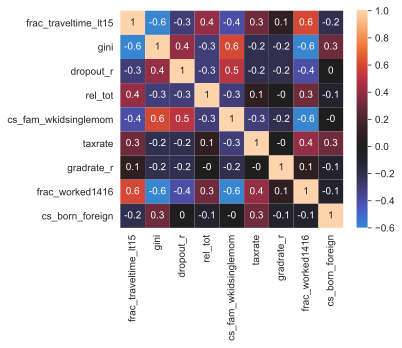

In [38]:
plt.figure(figsize=(5, 4))
sns.heatmap(df[predictors].corr().round(1), center=0, annot=True);

We see that `cs_fam_wkidsinglemom`, the fraction of families with a single mom,
has a high correlation with several other predictors, like `gini` and
`frac_worked1416`.
Here, we face a central tension in modeling.
If we want the most interpretable model, we should try to avoid collinearity.
For instance, we could remove variables that are highly correlated with others.
However, doing this often makes our model less accurate.
Having an interpretable model can mean having a less accurate model.
Is is better to have a highly interpretable model or a highly accurate one?
It depends.
Each modeling situation needs a different tradeoff, and it's the
job of the data scientist to understand and make this tradeoff.